In [33]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import pickle
import pandas_profiling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline


DIR = 'drive/My Drive/Colab Notebooks/Kaggle/animal'
DIR2 = './'
train_origin = pd.read_csv(os.path.join(DIR, 'train.csv.gz'))
train = train_origin.copy()
test_origin = pd.read_csv(os.path.join(DIR, 'test.csv.gz'))
test = test_origin.copy()
sub = pd.read_csv(os.path.join(DIR, 'sample_submission.csv.gz'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


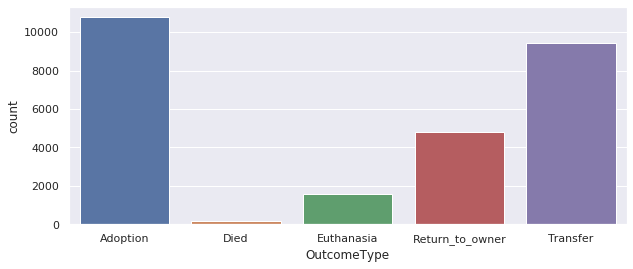

In [34]:
plt.figure(figsize=(10, 4))
sns.countplot(x='OutcomeType', data=train, order=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']);

In [35]:
train.head(2)
train.dtypes
# train["AnimalID"] = pd.to_numeric(train["AnimalID"], errors='coerce')


AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [37]:
pandas_profiling.ProfileReport(train)

OSError: ignored

In [0]:
test.dtypes

ID                 int64
Name              object
DateTime          object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

# 前処理基礎

In [0]:
# pathがなければ作成
def path_conf(path):
    if os.path.exists(path)==False:
        os.mkdir(path)

# numpy seedの固定
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# targetのエンコーディング(数値化)
def make_target(train):
    y_train = train['OutcomeType'].values
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    return y_train, le

# trainデータとtestデータの結合 df=func(a,b)
def df_trian_test_concat(train, test):
    train = train.drop(['OutcomeType', 'OutcomeSubtype'], axis=1)
    df = pd.concat([train, test], sort=False).reset_index(drop=True)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    use_col = [c for c in df.columns if c not in 'AnimalID']
    df = df[use_col]
    return df

# pandasの表示行数の設定
def pandas_view_rows(rows=60):
    print("今の設定:" + str(pd.get_option("display.max_rows"))+" 完了した設定の値:"+str(rows))
    pd.set_option('display.max_rows', rows)
    
# numpyの表示す桁数
def numpy_view_rows(rows=1000):
    np.set_printoptions(threshold=rows)

# 特徴量エンジニアリング

In [0]:
df = df_trian_test_concat(train, test)
df.head(3)

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [0]:
# func(dfcol)
def null0_notnull1(dfcol): 
    dfcol.fillna(0,inplace=True)
    dfcol.mask(dfcol != 0,1,inplace=True)
    
# df.col = func(df.col)
def null_or_not(dfcol):
    dfcol = dfcol.fillna(0)
    def atainosyori(x):
        if x == 0:
            return 0 #null
        else:
            return 1 #notnull
    return dfcol.apply(atainosyori)

In [0]:
# apply
def change_age(x):
    try:
        num, date = x.split(" ")
    except:
        return -999
    else:
        num = int(num)
        if date=='year' or date=='years':
            return num
        elif date=='month' or date=='months':
            return num/12
        elif date=='week' or date=='weeks':
            return num/52
        else:
            return num/365
# apply        
def mix_or_pure(breed):
    if "Mix" in breed:
        return 0 #"Mix"
    else:
        return 1 #"pure"

In [0]:
# df = func(df,dfcol)
def sexupon_matrix(df,dfcol):
    dfcol.fillna("a a",inplace=True)
    dfcol.replace("Unknown","a a",inplace=True)
    # 0_1
    intact_kyosei=[]
    # 0_1
    m_f=[]
    for i in dfcol:
        tmp= i.split(" ")
        if tmp[0] == "a":
            intact_kyosei.append(-1)
            m_f.append(-1)
        elif tmp[0] == "Intact":
            intact_kyosei.append(0)
            if tmp[1] == "Male":
                m_f.append(0)
            else:
                m_f.append(1)
        else:
            intact_kyosei.append(1)
            if tmp[1] == "Male":
                m_f.append(0)
            else:
                m_f.append(1)
    df = df.drop(dfcol.name,axis = 1)
    df["intact_kyosei"]=intact_kyosei
    df["m_f"] = m_f
    return df

In [0]:
#総まとめ
def make_feature(df):
    df['Name'] = null_or_not(df['Name'])
    df['AgeuponOutcome'] = df['AgeuponOutcome'].apply(change_age)
    df['Breed'] = df['Breed'].apply(mix_or_pure)
    df = sexupon_matrix(df,df['SexuponOutcome'])
    df[["Color_1", "Color_2"]] = df['Color'].str.split("/", expand=True)
    
    # datetime関連
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Dayofweek'] = df['DateTime'].dt.dayofweek
    df['hour'] = df['DateTime'].dt.hour
    df = df.drop('DateTime', axis=1)
    return df

In [0]:
df = df_trian_test_concat(train, test)
df = make_feature(df)

cat_col = [c for c in df.columns if df[c].dtype==object]
df[cat_col] = df[cat_col].fillna('missing')
for c in cat_col:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

X_train, X_test = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop=True)
y_train, le_target = make_target(train)

In [0]:
X_train.head(10)

,Name,AnimalType,AgeuponOutcome,Breed,Color,intact_kyosei,m_f,Color_1,Color_2,Year,Month,Day,Dayofweek,hour
0,1,1,1.000000,0,146,1,0,15,43,2014,2,12,2,18
1,1,0,1.000000,0,184,1,1,26,46,2013,10,13,6,12
2,1,1,2.000000,0,97,1,0,7,43,2015,1,31,5,12
3,0,0,0.057692,0,47,0,0,8,46,2014,7,11,4,19
4,0,1,2.000000,1,311,1,0,49,46,2013,11,15,4,12
5,1,1,0.083333,1,40,0,1,2,39,2014,4,25,4,13
6,1,0,0.057692,0,70,0,0,12,46,2015,3,28,5,13
7,0,0,0.057692,0,117,-1,-1,18,46,2015,4,30,3,17
8,1,1,0.416667,0,283,1,1,40,43,2014,2,4,1,17
9,0,1,1.000000,1,359,1,1,54,46,2014,5,3,5,7


In [0]:
pandas_profiling.ProfileReport(X_train)

Number of variables,14
Number of observations,26729
Total Missing (%),0.0%
Total size in memory,2.9 MiB
Average record size in memory,112.0 B
Numeric,10
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,1


# 学習

In [0]:
TEST_CODE = False
SEED = 42
N_FOLDS = 5
N_CLASS = 5
MODEL_SAVE_DIR = os.path.join(DIR, './models')
CSV_SAVE_DIR = os.path.join(DIR, './pred_csv')
PREDICTION_NO = '01'
TEAM_NAME = 'uzu-kumaru'
PARAM = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': N_CLASS,
    'seed': SEED,
    'num_leaves': 30,
    'learning_rate': 0.01,
}

if TEST_CODE:
    X_train, y_train = X_train.iloc[8000:10000, :], y_train[8000:10000]
    X_test = X_test[:1000]
    sub = sub[:1000]

In [0]:
def run1():
    seed_everything(SEED)
    path_conf(MODEL_SAVE_DIR)
    oof = np.zeros((X_train.shape[0], N_CLASS))
    pred = np.zeros((X_test.shape[0], N_CLASS))
    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
    for i, (tr_ix, va_ix) in enumerate(skf.split(X_train, y_train)):
        print(f'===== Fold {i+1}/{N_FOLDS}    Start =====\n')
        start_time = time.time()
        X_tr, y_tr = X_train.iloc[tr_ix, :], y_train[tr_ix]
        X_va, y_va = X_train.iloc[va_ix, :], y_train[va_ix]

        tra_dataset = lgb.Dataset(X_tr, y_tr)
        val_dataset = lgb.Dataset(X_va, y_va)
        model = lgb.train(PARAM,
                         tra_dataset,
                         num_boost_round=10000,
                         valid_sets=val_dataset,
                         early_stopping_rounds=30,
                         verbose_eval=False,)
        oof[va_ix] = model.predict(X_va)
        pred += model.predict(X_test) / skf.n_splits

        val_score = log_loss(y_va, oof[va_ix])
        print(f'Validation Score: {val_score:.3f}\n')

        end_time = time.time()
        print(f'timer:  {(end_time - start_time):.3f} sec.\n')

        lgb.plot_importance(model, figsize=(6, 4), importance_type='gain')
        print()

        with open(os.path.join(MODEL_SAVE_DIR, f'model_{i+1}.pkl'), 'wb') as f:
            pickle.dump(model, f)
            
    val_score = log_loss(y_train, oof)
    print(f'\n\nTotal Validation Score: {val_score:.3f}\n')
            
    return oof, pred

===== Fold 1/5    Start =====

Validation Score: 0.755

timer:  27.250 sec.


===== Fold 2/5    Start =====

Validation Score: 0.745

timer:  26.010 sec.


===== Fold 3/5    Start =====

Validation Score: 0.758

timer:  28.895 sec.


===== Fold 4/5    Start =====

Validation Score: 0.762

timer:  20.595 sec.


===== Fold 5/5    Start =====

Validation Score: 0.768

timer:  22.773 sec.




Total Validation Score: 0.758



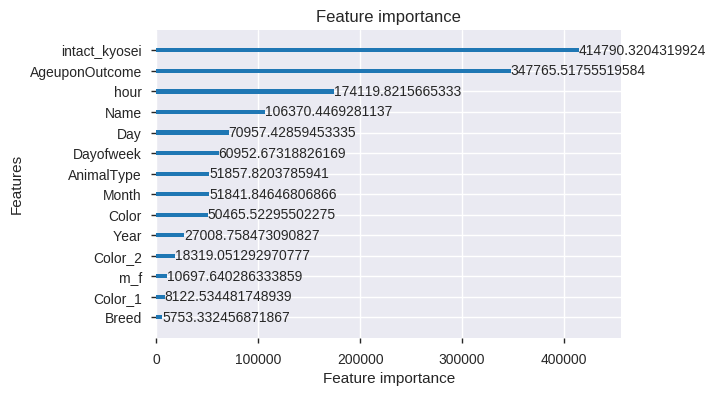

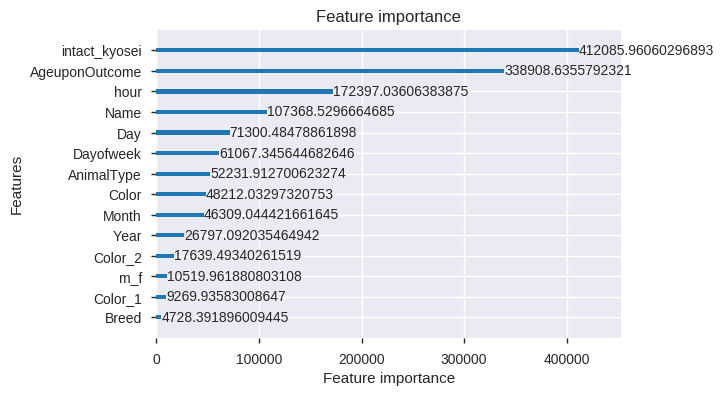

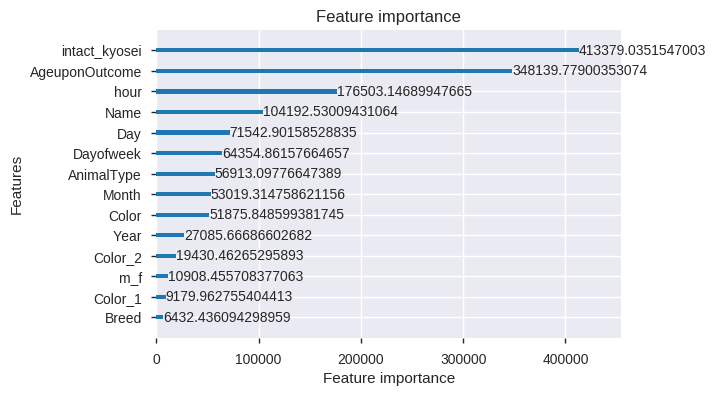

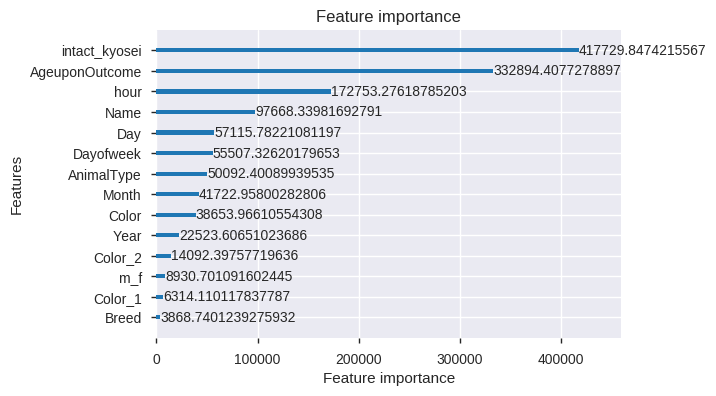

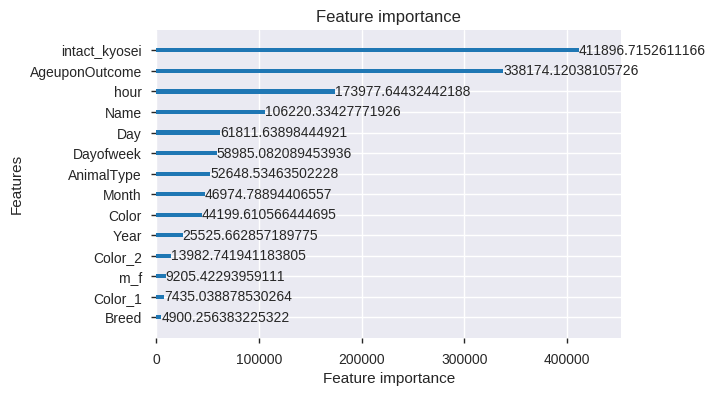

In [0]:
oof1, pred1 = run1()

In [0]:
sub.iloc[:, 1:] = pred1
sub.to_csv(f'{CSV_SAVE_DIR}/submission_{TEAM_NAME}_{PREDICTION_NO}.csv', index=False)

In [0]:
pip show pandas-profiling

Name: pandas-profiling
Version: 1.4.1
Summary: Generate profile report for pandas DataFrame
Home-page: http://github.com/jospolfliet/pandas-profiling
Author: Jos Polfliet
Author-email: jos.polfliet+panpro@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: matplotlib, six, jinja2, pandas
Required-by: 


absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.0.1
asgiref==3.2.3
astor==0.8.1
astroid==2.3.3
astropy==4.0
atari-py==0.2.6
atomicwrites==1.3.0
attr==0.3.1
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.4.0
boto==2.49.0
boto3==1.11.15
botocore==1.14.15
Bottleneck==1.3.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.11.28
cffi==1.14.0
chainer==6.5.0
chardet==3.0.4
chart-studio==1.0.0
Click==7.0
cloudpickle==1.2.2
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
confuse==1.0.0
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.0
cupy-cuda101==6.5.0
cvxopt==1.2.4
cvxpy==1.0.25
cycler==0.10.0
cymem==2.0.3
Cython==0.29.15
daft==0.0.4
dask==2.9.2
dataclasses==0.7
datascience==0.10.6
decorator==4.4.1
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
